### [kdegrave.github.io](https://kdegrave.github.io/)

### Introduction

The Federal National Mortgage Association (FNMA), commonly known as Fannie Mae, is a government-sponsored corporation founded in 1938. Fannie Mae's primary role involves purchasing mortgage loans from major lenders like Bank of America and Wells Fargo, among others. Fannie Mae transforms these mortgages into securities that are traded in the bond market. These sales provide lenders with increased liquidity to fund more mortgages. Until 2008, these mortgage-backed securities were widely regarded as secure investments. 

However, not all borrowers whose loans are aquired by Fannie Mae can meet their mortgage repayment obligations, leading to instances of default. Unfortunately, by 2008, a substantial number of borrowers had defaulted on their loans. This wave of defaults significantly devalued mortgage-backed securities and had a profound impact on the global economy.

The objective of this project is to create a predictive model capable of identifying borrowers who are at risk of defaulting on their mortgages. Fannie Mae has made its Single Family Loan Performance (SFLP) data publicly accessible for all years starting from 1999, and this will serve as the basis for model development. Due to the extensive volume of data available - totaling several hundred gigabytes - the analysis will focus on loans originating during the first quarter of 2008. This specific time frame contains an unusually large proportion of mortgages that went into default, allowing us to efficiently build up a suitable training set.

The dataset for this analysis is approximately 6GB in size and does not contain column headers. Fortunately, Fannie Mae also provides a glossary describing the data layout with definitions and data types for each of the fields. The glossary will help us quickly get a sense of what is contained in the larger SFLP dataset.

Let's import some useful libraries and read the glossary file.

### Data Ingestion

In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib.pyplot import *
from joblib import dump
import pandas as pd
import numpy as np
import os

from hyperopt import space_eval, Trials, STATUS_OK
from hyperopt import fmin, hp, tpe
from hyperopt.pyll import scope

pd.set_option('display.max_columns', 500)

In [3]:
glossary = pd.read_excel('data/crt-file-layout-and-glossary.xlsx', sheet_name='Combined Glossary')

In [4]:
glossary.head()

,Field Position,Field Name,Description,Date Bound Notes,Respective Disclosure Notes,CAS,CIRT,Single-Family (SF) Loan Performance,Type,Max Length
0,1,Reference Pool ID,A unique identifier for the reference pool.,NaN,NaN,√,√,NaN,ALPHA-NUMERIC,X(4)
1,2,Loan Identifier,A unique identifier for the mortgage loan.,NaN,The Loan Identifier does not correspond to oth...,√,√,√,ALPHA-NUMERIC,X(12)
2,3,Monthly Reporting Period,The month and year that pertains to the servic...,SF Loan Performance: Enhanced format with the ...,NaN,√,√,√,DATE,MMYYYY
3,4,Channel,The origination channel used by the party that...,NaN,Retail = R; Correspondent = C; Broker = B,√,√,√,ALPHA-NUMERIC,X(1)
4,5,Seller Name,The name of the entity that delivered the mort...,NaN,CAS/CIRT: For sellers whose combined loans' co...,√,√,√,ALPHA-NUMERIC,X(50)


There are 108 fields in the ```Field Name``` column, with their position in the SFLP dataset indicated by the ```Field Position``` We can combine the ```Field Name``` and ```Type``` columns as a dictionary which can be used to ensure that the appropriate data types are preserved when reading the SFLP dataset. 

In [5]:
dtype = dict(
    zip(
        glossary['Field Name'].tolist(),
        glossary['Type'].replace({'NUMERIC': 'float', 'NUMERIC ': 'float', 'ALPHA-NUMERIC': 'object', 'DATE': 'object'})
    )
)

A sample of the SFLP data can now be read in and displayed.

In [6]:
pd.read_csv('data/2008Q1.csv', sep='|', nrows=5, names=glossary['Field Name'], dtype=dtype)

,Reference Pool ID,Loan Identifier,Monthly Reporting Period,Channel,Seller Name,Servicer Name,Master Servicer,Original Interest Rate,Current Interest Rate,Original UPB,UPB at Issuance,Current Actual UPB,Original Loan Term,Origination Date,First Payment Date,Loan Age,Remaining Months to Legal Maturity,Remaining Months To Maturity,Maturity Date,Original Loan to Value Ratio (LTV),Original Combined Loan to Value Ratio (CLTV),Number of Borrowers,Debt-To-Income (DTI),Borrower Credit Score at Origination,Co-Borrower Credit Score at Origination,First Time Home Buyer Indicator,Loan Purpose,Property Type,Number of Units,Occupancy Status,Property State,Metropolitan Statistical Area (MSA),Zip Code Short,Mortgage Insurance Percentage,Amortization Type,Prepayment Penalty Indicator,Interest Only Loan Indicator,Interest Only First Principal And Interest Payment Date,Months to Amortization,Current Loan Delinquency Status,Loan Payment History,Modification Flag,Mortgage Insurance Cancellation Indicator,Zero Balance Code,Zero Balance Effective Date,UPB at the Time of Removal,Repurchase Date,Scheduled Principal Current,Total Principal Current,Unscheduled Principal Current,Last Paid Installment Date,Foreclosure Date,Disposition Date,Foreclosure Costs,Property Preservation and Repair Costs,Asset Recovery Costs,Miscellaneous Holding Expenses and Credits,Associated Taxes for Holding Property,Net Sales Proceeds,Credit Enhancement Proceeds,Repurchase Make Whole Proceeds,Other Foreclosure Proceeds,Modification-Related Non-Interest Bearing UPB,Principal Forgiveness Amount,Original List Start Date,Original List Price,Current List Start Date,Current List Price,Borrower Credit Score At Issuance,Co-Borrower Credit Score At Issuance,Borrower Credit Score Current,Co-Borrower Credit Score Current,Mortgage Insurance Type,Servicing Activity Indicator,Current Period Modification Loss Amount,Cumulative Modification Loss Amount,Current Period Credit Event Net Gain or Loss,Cumulative Credit Event Net Gain or Loss,Special Eligibility Program,Foreclosure Principal Write-off Amount,Relocation Mortgage Indicator,Zero Balance Code Change Date,Loan Holdback Indicator,Loan Holdback Effective Date,Delinquent Accrued Interest,Property Valuation Method,High Balance Loan Indicator,ARM Initial Fixed-Rate Period ≤ 5 YR Indicator,ARM Product Type,Initial Fixed-Rate Period,Interest Rate Adjustment Frequency,Next Interest Rate Adjustment Date,Next Payment Change Date,Index,ARM Cap Structure,Initial Interest Rate Cap Up Percent,Periodic Interest Rate Cap Up Percent,Lifetime Interest Rate Cap Up Percent,Mortgage Margin,ARM Balloon Indicator,ARM Plan Number,Borrower Assistance Plan,High Loan to Value (HLTV) Refinance Option Indicator,Deal Name,Repurchase Make Whole Proceeds Flag,Alternative Delinquency Resolution,Alternative Delinquency Resolution Count,Total Deferral Amount
0,NaN,100001806951,022008,R,Other,Other,NaN,6.125,6.125,177000.0,NaN,0.0,360.0,012008,032008,0.0,360.0,359.0,022038,47.0,47.0,1.0,NaN,662.0,NaN,N,C,SF,1.0,P,CA,12540,935,NaN,FRM,N,N,NaN,NaN,00,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN
1,NaN,100001806951,032008,R,Other,Other,NaN,6.125,6.125,177000.0,NaN,0.0,360.0,012008,032008,1.0,359.0,359.0,022038,47.0,47.0,1.0,NaN,662.0,NaN,N,C,SF,1.0,P,CA,12540,935,NaN,FRM,N,N,NaN,NaN,00,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN
2,NaN,100001806951,042008,R,Other,Other,NaN,6.125,6.125,177000.0,NaN,0.0,360.0,012008,032008,2.0,358.0,358.0,022038,47.0,47.0,1.0,NaN,662.0,NaN,N,C,SF,1.0,P,CA,12540,935,NaN,FRM,N,N,NaN,NaN,00,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

The data contains a loan identification number along with information regarding the loan servicer, interest rate, loan term, and loan age. The full dataset is large but can be read and processed in chunks so that the entire thing won't have to be held in memory. Default loan identifiers will be extracted directly before breaking the dataset into pieces. This avoids inadvertently assigning some defaults to the non-default group in cases where division of the dataset causes loan histories to be split.

Let's write some code to ingest the data and identify defaults. 

In [7]:
da = pd.read_csv('data/2008Q1.csv', sep='|', names=glossary['Field Name'], dtype=dtype,
                 usecols=['Loan Identifier', 'Origination Date', 'Foreclosure Date', 'Loan Age'])

da['Origination Date'] = pd.to_datetime(da['Origination Date'], format='%m%Y')
da['Foreclosure Date'] = pd.to_datetime(da['Foreclosure Date'], format='%m%Y')

default_loan_identifier = da[da['Foreclosure Date'] < da['Origination Date'] + pd.DateOffset(years=5)][['Loan Identifier']].drop_duplicates()

Now that the default loan indentifiers are extracted in hand, the data can be processed.

In [8]:
for da in pd.read_csv('data/2008Q1.csv', sep='|', names=glossary['Field Name'], dtype=dtype, chunksize=100000):

    da['Origination Date'] = pd.to_datetime(da['Origination Date'], format='%m%Y')
    da['Foreclosure Date'] = pd.to_datetime(da['Foreclosure Date'], format='%m%Y')

    da = da[
        (da['Origination Date'] >= '2008-01-01') &
        (da['Origination Date'] <= '2008-03-31')
    ].sort_values(['Loan Identifier', 'Loan Age'])

    # Isolate default data
    default = da.merge(default_loan_identifier, on='Loan Identifier', how='inner')

    default = default[default['Loan Age'].isin([0, 1])].drop_duplicates('Loan Identifier', keep='first').reset_index(drop=True)

    # Isolate non-default data
    non_default = da.merge(default_loan_identifier, on='Loan Identifier', how='left', indicator=True)

    non_default = non_default[
        (non_default['_merge'] == 'left_only') &
        (non_default['Loan Age'].isin([0, 1]))
    ].drop('_merge', axis=1).drop_duplicates('Loan Identifier', keep='first').reset_index(drop=True)

    default.to_csv('data/default_2008Q1.csv', mode='a', index=False, header=not os.path.exists('data/default_2008Q1.csv'))

    non_default.to_csv('data/non_default_2008Q1.csv', mode='a', index=False, header=not os.path.exists('data/non_default_2008Q1.csv'))

The first few lines of code above ensure that the loan origination dates fall within the first quarter of 2008. Even though this *should* be true by default, a percentage of loans fall outside of this range. Mortgage defaults are then identified based on the presence of a non-null value in the ```Foreclosure Date``` column. For each default, the data row corresponding to the earliest ```Loan Age``` value is extracted. The goal here is to ensure the model only learns from data that would have been available at or near the time of origination. Non-default loans are simply those that do not fall into the default group.

### Data Exploration

With the dataset now prepared, it can be used for exploratory analysis. A ```Target``` column is created where default and non-default loans are given values of 0 and 1 respectively. This will be used in modeling later.

In [9]:
default_loans = pd.read_csv('data/default_2008Q1.csv')

non_default_loans = pd.read_csv('data/non_default_2008Q1.csv')

In [10]:
default_loans['Target'] = 1

non_default_loans['Target'] = 0

In [11]:
df = pd.concat([default_loans, non_default_loans], axis=0).reset_index(drop=True)

df.columns = [i.strip() for i in df.columns]

In [12]:
print(f"""
    Number rows: {df.shape[0]}
    Number columns: {df.shape[1]}
    Number null columns: {((df.isnull().sum()/len(df)) == 1).sum()}
    Number non-defaults: {df[df['Target'] == 0].shape[0]}
    Number defaults: {df[df['Target'] == 1].shape[0]}
""")


    Number rows: 244109
    Number columns: 109
    Number null columns: 66
    Number of non-defaults: 234569
    Number of defaults: 9540



There are over 244k total records in the data, with 9.5k defaults. More than sixty columns are completely null. These can be removed from the dataset.

In [13]:
df.dropna(axis=1, how='all', inplace=True)

Some remaining columns contain redundant entries or values that would not have been available at the time of loan origination (e.g., ```Current Loan Delinquency Status```), while others contain only a single value (e.g., ```High Balance Loan Indicator```). These can also be removed from the dataset.

In [14]:
columns_to_remove = [
    'Loan Identifier',
    'Monthly Reporting Period',
    'Seller Name',
    'Current Interest Rate',
    'Current Actual UPB',
    'Origination Date',
    'First Payment Date',
    'Loan Age',
    'Remaining Months to Legal Maturity',
    'Remaining Months To Maturity',
    'Maturity Date',
    'Amortization Type',
    'Prepayment Penalty Indicator',
    'Current Loan Delinquency Status',
    'Modification Flag',
    'Servicing Activity Indicator',
    'Special Eligibility Program',
    'Relocation Mortgage Indicator',
    'High Balance Loan Indicator',
    'High Loan to Value (HLTV) Refinance Option Indicator'
]

In [15]:
df.drop(columns_to_remove, axis=1, inplace=True)

Let's check the proportion of null values in the remaining columns.

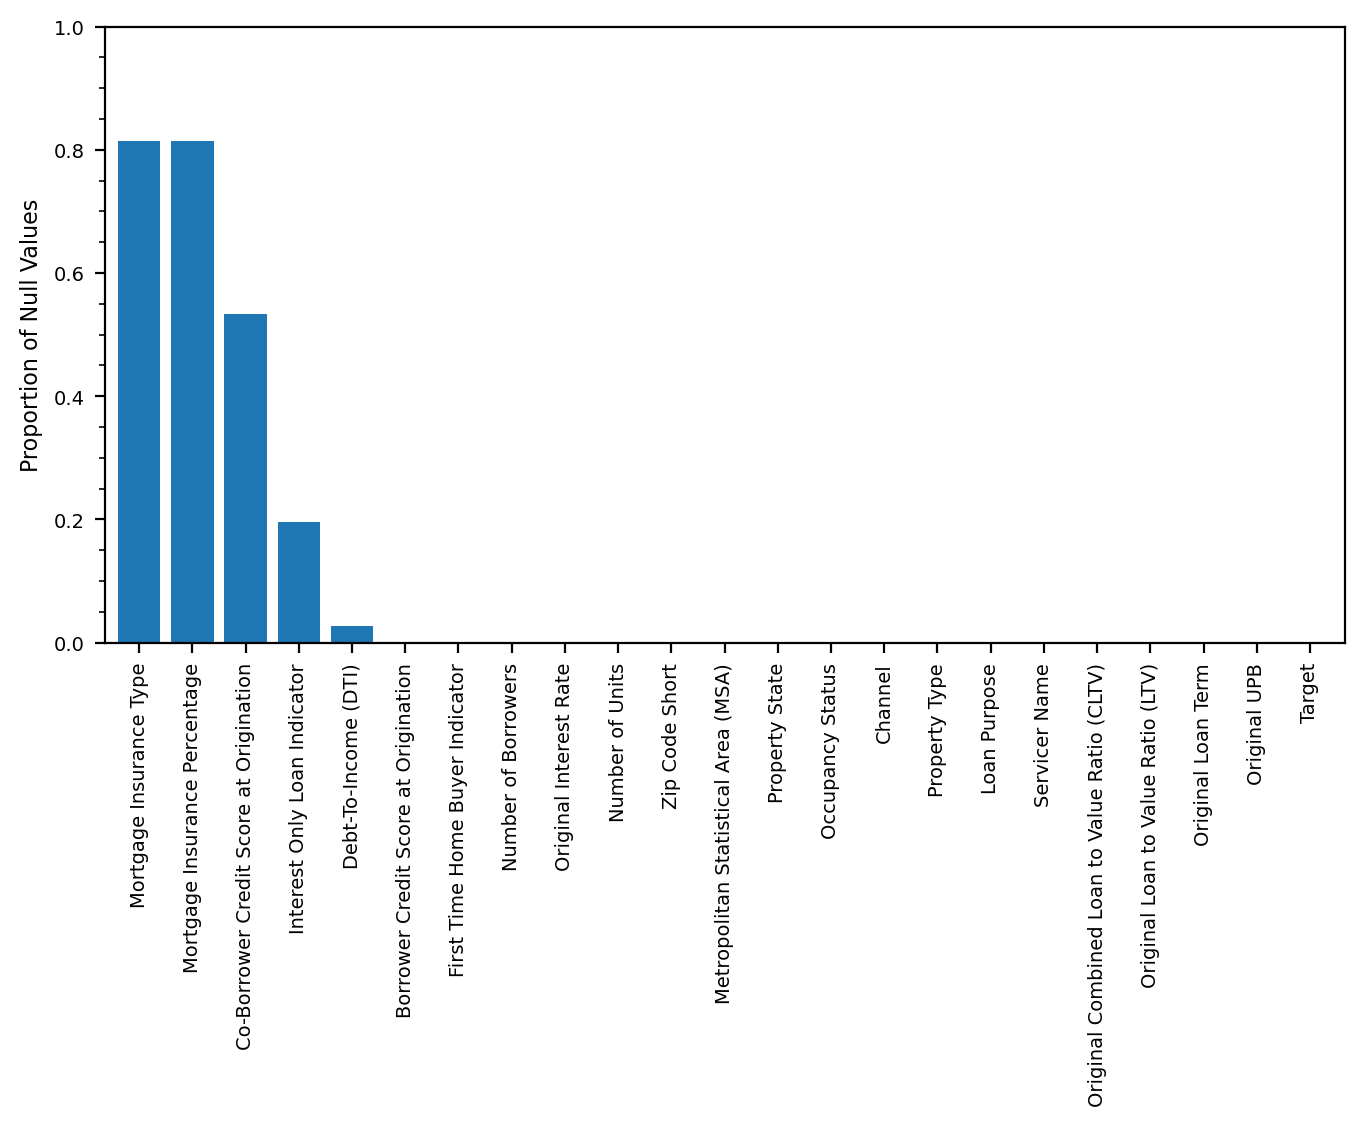

In [16]:
ax = df.isnull().sum().divide(len(df)).sort_values(ascending=False).plot.bar(width=0.8, figsize=(8, 4), fontsize=7)

ax.set_ylim(0, 1)

ax.minorticks_on()
ax.xaxis.set_tick_params(which='minor', bottom=False)
ax.yaxis.set_tick_params(which='minor', bottom=True)

ax.set_ylabel('Proportion of Null Values', fontsize=8);

The data can be explored for any interesting trends or to get a sense of which columns might be useful in identifying default borrowers.

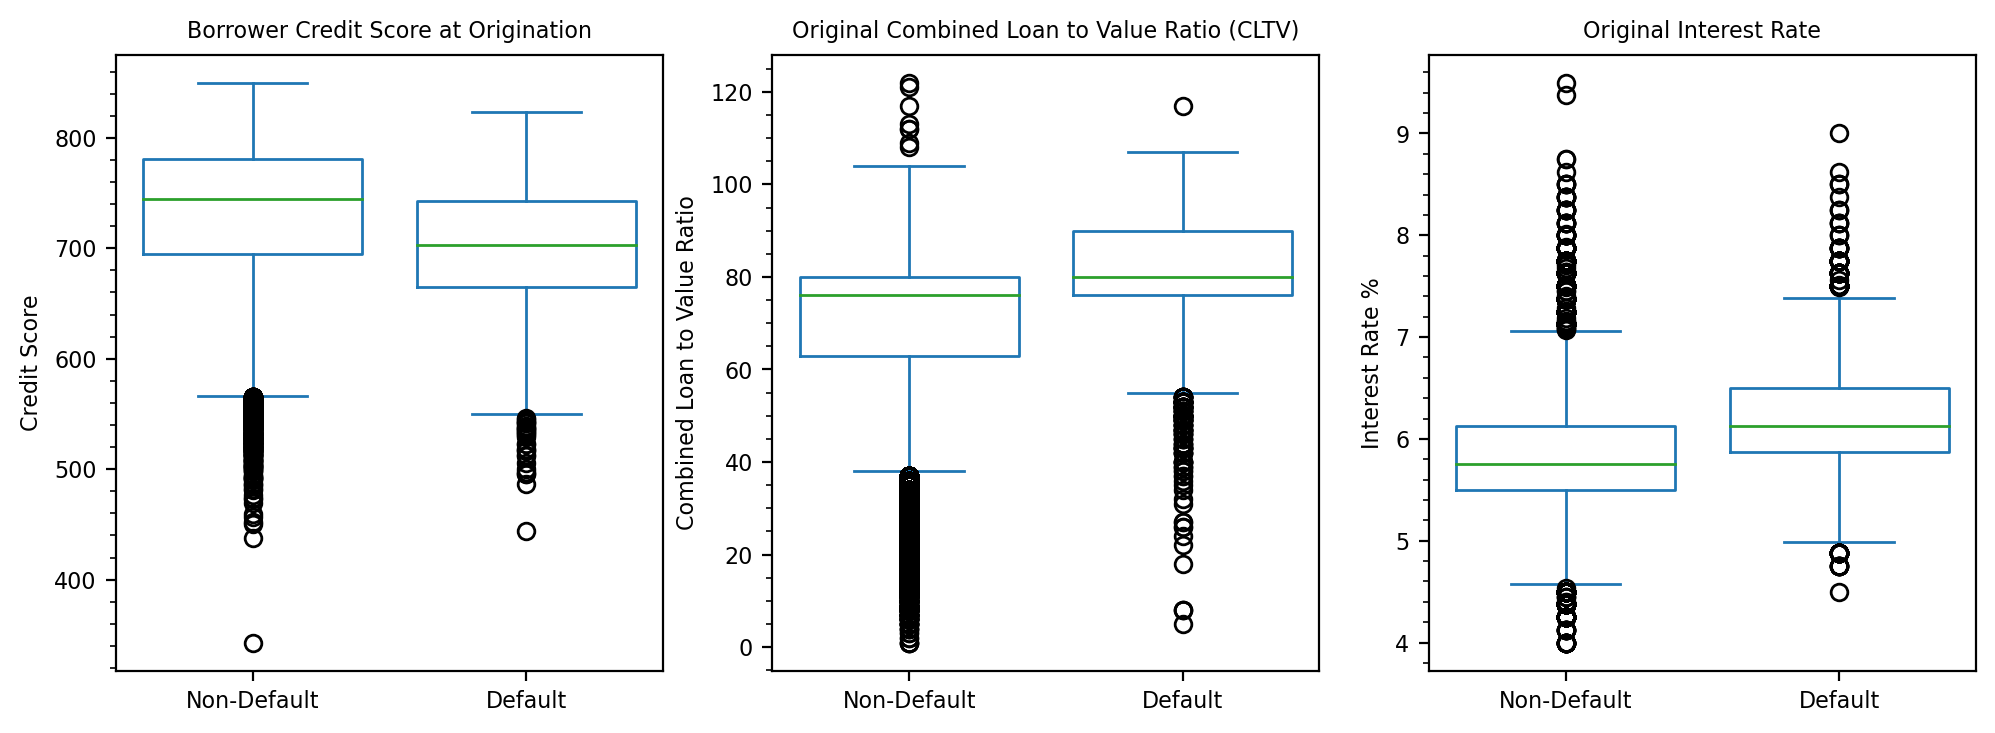

In [17]:
fig, axs = subplots(nrows=1, ncols=3, figsize=(12, 4))

df.plot.box(column='Borrower Credit Score at Origination', by='Target', widths=0.8, ax=axs[0], fontsize=8)

df.plot.box(column='Original Combined Loan to Value Ratio (CLTV)', by='Target', widths=0.8, ax=axs[1], fontsize=8)

df.plot.box(column='Original Interest Rate', by='Target', widths=0.8, ax=axs[2], fontsize=8)

axs[0].set_title('Borrower Credit Score at Origination', fontsize=8)
axs[0].set_ylabel('Credit Score', fontsize=8)
axs[0].set_xticklabels(['Non-Default', 'Default'], fontsize=8)

axs[1].set_title('Original Combined Loan to Value Ratio (CLTV)', fontsize=8)
axs[1].set_ylabel('Combined Loan to Value Ratio', fontsize=8)
axs[1].set_xticklabels(['Non-Default', 'Default'], fontsize=8)

axs[2].set_title('Original Interest Rate', fontsize=8)
axs[2].set_ylabel('Interest Rate %', fontsize=8)
axs[2].set_xticklabels(['Non-Default', 'Default'], fontsize=8)

for i, j in enumerate(axs):
    axs[i].minorticks_on()
    axs[i].xaxis.set_tick_params(which='minor', bottom=False)
    axs[i].yaxis.set_tick_params(which='minor', bottom=True)

On average, default borrowers have lower credit scores, higher loan-to-value ratios, and higher interest rates.

### Feature Engineering

The existing data can be used to engineer new features that might give the model extra predictive power.

The dataset includes a column named ```Zip Code Short```, which corresponds to the first three digits of the ZIP code associated with the location of each mortgaged property. This information could be prove valuable if default borrowers tend to be clustered geographically. ZIP codes function as categorical features, with their digits offering progressively finer levels of geospatial detail as more values are included. For example, while the first digit of a ZIP code indicates a broad geographic area encompassing multiple neighboring states, a complete five-digit ZIP code reaches the sub-county level within a state.

There are nearly one thousand distinct three-digit ZIP codes in the data, and using all of them as categorical features may prove intractable. Using the first (or first two) digits might offer a more manageable solution, but there's another option. The latitude and longitude centroids for each three-digit ZIP code can be computed and incorporated as numeric features in the model. This approach preserves the original granularity of the three-digit ZIP codes without necessitating the encoding of numerous categorical features.

To do this, let's first read in a file that maps complete five-digit ZIP codes to their latitude and longitude coordinates.

In [18]:
zip_code_map = pd.read_csv('data/us_zip_codes.txt', sep='\t', header=None, 
                           usecols=[1, 9, 10], names=['Zip Code', 'Latitude', 'Longitude'], dtype={'Zip Code': str})

In [19]:
zip_code_map.head()

,Zip Code,Latitude,Longitude
0,99553,54.1430,-165.7854
1,99571,55.1858,-162.7211
2,99583,54.8542,-163.4113
3,99612,55.0628,-162.3056
4,99661,55.3192,-160.4914


The first three digits of each ZIP code are isolated and grouped, and their average latitude and longitude are computed.

In [20]:
zip_code_map['Zip Code Short'] = zip_code_map['Zip Code'].apply(lambda x: x[:3])

zip_code_map = zip_code_map.groupby('Zip Code Short')[['Latitude', 'Longitude']].mean().reset_index()

In [21]:
df['Zip Code Short'] = df['Zip Code Short'].astype(str).str.zfill(3)

In [22]:
df = df.merge(zip_code_map, on='Zip Code Short')

We can now drop the ```Zip Code Short``` column along with ```Property State``` and ```Metropolitan Statistical Area (MSA)``` since each are effectively encoded within the latitude longitude coordinates.

In [23]:
df.drop(['Zip Code Short', 'Property State', 'Metropolitan Statistical Area (MSA)'], axis=1, inplace=True)

The data are split into training and test sets for model training.

In [24]:
x_tr, x_te, y_tr, y_te = train_test_split(df.drop('Target', axis=1), df['Target'], test_size=0.2, random_state=0)

### Model Training

Prior experimentation indicates that tree-based models, specifically gradient-boosted decision trees, perform well within this problem domain. In a gradient-boosted model, many weak learners are combined to produce one stronger ensemble learner. This model will be integrated as part of a scikit-learn pipeline, facilitating the seamless chaining of multiple processing stages (e.g., one-hot encoding and feature scaling) into one cohesive workflow.

We can process the categorical and numerical features separately in the pipeline. They are quickly identified by examining column data types.

In [25]:
categorical_columns = x_tr.select_dtypes('object').columns.tolist()

numerical_columns = x_tr.select_dtypes('number').columns.tolist()

Missing values in the numerical data are filled with a constant value of -1 to convey to the model that they were not populated. Other common strategies for imputation include filling missing values with the column mean, median, or mode. The categorical features are imputed similarly, and are also one-hot encoded.

In [26]:
numerical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=-1))
    ]
)

In [27]:
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing_value')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]
)

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_columns),
        ('categorical', categorical_transformer, categorical_columns)
    ]
)

The gradient-boosted decision tree model has several hyperparameters which can be tuned to improve performance. There are several ways to do this, but we will employ the Hyperopt library for optimization. Unlike a brute-force grid search, which can be time-consuming and resource intensive, Hyperopt attempts to find a suitable set of hyperparameters using Bayesian optimization techniques, sidestepping the need to test every combination directly. Cross-validation is used to evaluate model performance and to avoid overfitting.

In [29]:
search_space = {
    'max_iter':          scope.int(hp.quniform('max_iter', 10, 350, q=1)),
    'learning_rate':     10**hp.uniform('learning_rate', -2, 0),
    'max_depth':         scope.int(hp.quniform('max_depth', 1, 20, q=1)),
    'max_leaf_nodes':    scope.int(hp.quniform('max_leaf_nodes', 3, 100, q=1)),
    'min_samples_leaf':  scope.int(hp.quniform('min_samples_leaf', 1, 100, q=1)),
    'l2_regularization': 10**hp.uniform('l2_regularization', -3, 3),
    'max_bins':          scope.int(hp.quniform('max_bins', 10, 255, q=1))
}

trials = Trials()

def objective(params):

    pipeline = Pipeline(
        steps = [
            ('preprocessor', preprocessor),
            ('classifier', HistGradientBoostingClassifier(**params, class_weight='balanced',
                                                          loss='log_loss', early_stopping='auto',
                                                          validation_fraction=0.2, random_state=0))
        ]
    )

    scores = cross_val_score(pipeline, x_tr, y_tr, cv=10, scoring='roc_auc', n_jobs=5)

    return {'loss': -scores.mean(), 'std': scores.std(), 'model': pipeline, 'status': STATUS_OK}

best_trial = fmin(fn=objective, space=search_space, algo=tpe.suggest, max_evals=25, trials=trials)

100%|████████| 25/25 [06:28<00:00, 15.55s/trial, best loss: -0.8541255761339249]


Cross-validation suggests the model achieves an ROC AUC score of 0.85. Let's view the hyperparameters for the best model.

In [30]:
best_params = space_eval(search_space, best_trial)

In [31]:
print(best_params)

{'l2_regularization': 541.2969678029971, 'learning_rate': 0.30395863724045935, 'max_bins': 180, 'max_depth': 16, 'max_iter': 162, 'max_leaf_nodes': 21, 'min_samples_leaf': 7}


In [32]:
best_model = trials.best_trial['result']['model']

best_model.fit(x_tr, y_tr)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-1,
                                                                                 strategy='constant'))]),
                                                  ['Original Interest Rate',
                                                   'Original UPB',
                                                   'Original Loan Term',
                                                   'Original Loan to Value '
                                                   'Ratio (LTV)',
                                                   'Original Combined Loan to '
                                                   'Value Ratio (CLTV)',
                                                   'Number of Borrowers',
                                                   'Debt-To-Income (DTI)',
                                                   'Borrower Credit Sco...
                                                   'Indicator',
                                                   'Loan Purpose',
                                                   'Property Type',
                                                   'Occupancy Status',
                                                   'Interest Only Loan '
                                                   'Indicator'])])),
                ('classifier',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                l2_regularization=541.2969678029971,
                                                learning_rate=0.30395863724045935,
                                                max_bins=180, max_depth=16,
                                                max_iter=162, max_leaf_nodes=21,
                                                min_samples_leaf=7,
                                                random_state=0,
                                                validation_fraction=0.2))])

The model can now be saved.

In [33]:
dump(best_model, 'models/loan_default_model.joblib')

['models/loan_default_model.joblib']

### Model Evaluation

The trained model can now be evaluated by applying it to the test data.

In [34]:
predict_proba = best_model.predict_proba(x_te)[:, 1]

In [35]:
fp, tp, threshold = roc_curve(y_te, predict_proba)

In [36]:
score = roc_auc_score(y_te, predict_proba)

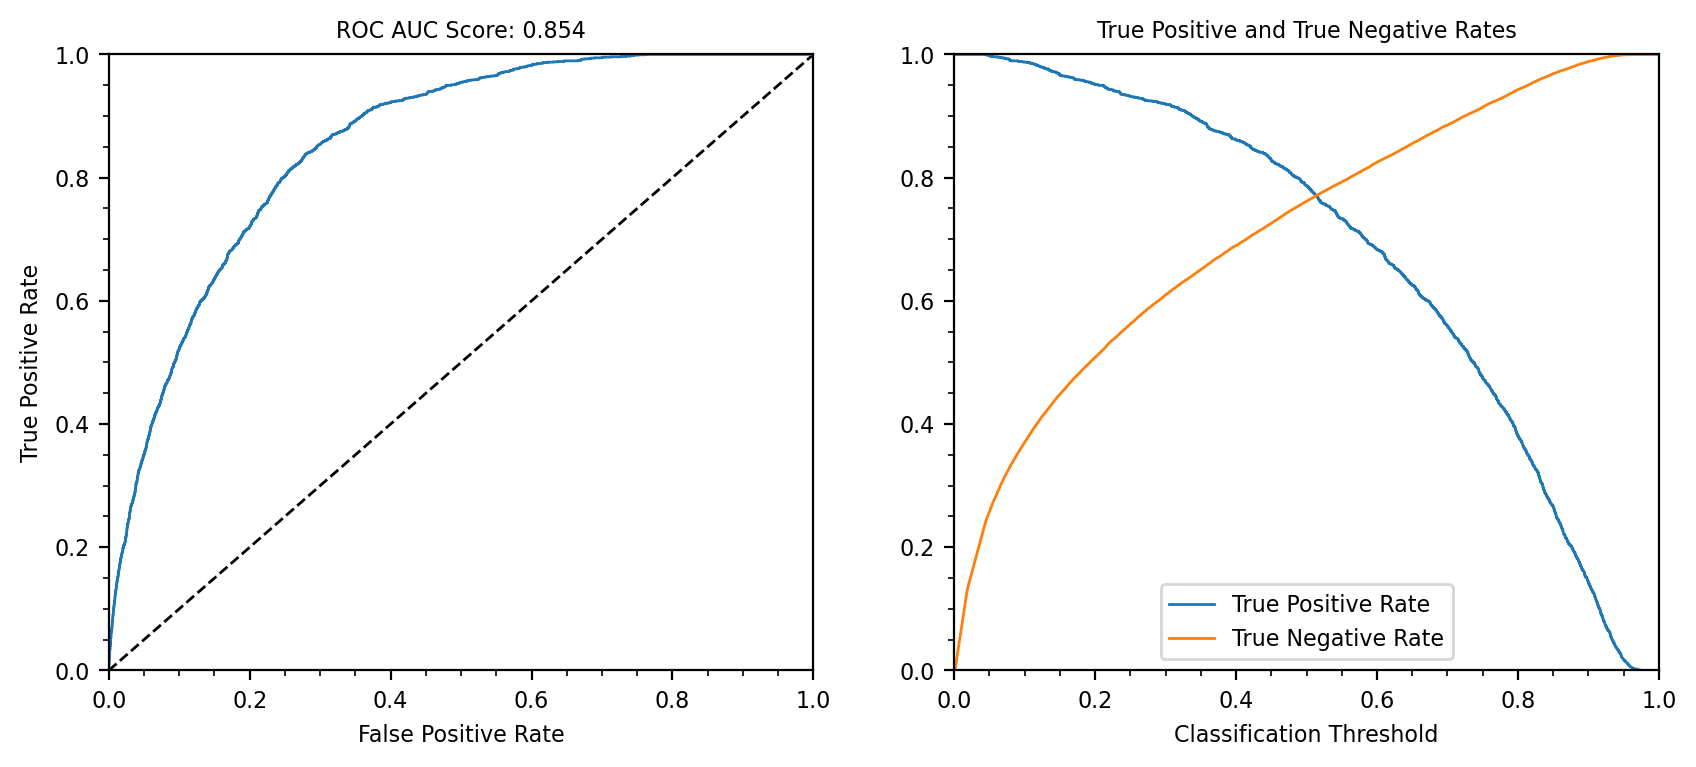

In [37]:
fig, axs = subplots(nrows=1, ncols=2, figsize=(10, 4))

axs[0].plot([0, 1], [0, 1], lw=1, ls='--', c='k')

axs[0].plot(fp, tp, lw=1)
axs[0].set_ylim(0, 1)
axs[0].set_xlim(0, 1)
axs[0].set_ylabel('True Positive Rate', fontsize=8)
axs[0].set_xlabel('False Positive Rate', fontsize=8)
axs[0].set_title(f'ROC AUC Score: {score.round(3)}', fontsize=8)

axs[1].plot(threshold, tp, lw=1)
axs[1].plot(threshold, 1 - fp, lw=1)
axs[1].set_ylim(0, 1)
axs[1].set_xlim(0, 1)
axs[1].set_xlabel('Classification Threshold', fontsize=8)
axs[1].set_title('True Positive and True Negative Rates', fontsize=8)
axs[1].legend(['True Positive Rate', 'True Negative Rate'], fontsize=8)

for i, j in enumerate(axs):
    axs[i].minorticks_on()
    axs[i].tick_params(axis='both', labelsize=8)

The left-hand figure shows the resulting ROC curve after applying the model to the test data. The AUC score of 0.85 is in line with our expectations based on cross-validation performed during training. The right-hand figure shows the model's true positive and true negative rates as a function of the decision threshold. These curves offer insight into how false positives and false negatives could be balanced based on business objectives and associated costs. For instance, within the context of mortgage loans, a false negative holds a higher potential cost compared to a false positive. In other words, granting a loan to a borrower who subsequently defaults is more costly than denying a loan to a borrower who is predicted to default but does not.

Finally, permutation importance can be employed to gain insight into which features had the most influence on model performance.

In [38]:
result = permutation_importance(best_model, x_te, y_te, scoring='roc_auc', n_repeats=10, random_state=0, n_jobs=-1)

sorted_importances_idx = result.importances_mean.argsort()

importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=x_te.columns[sorted_importances_idx],
)

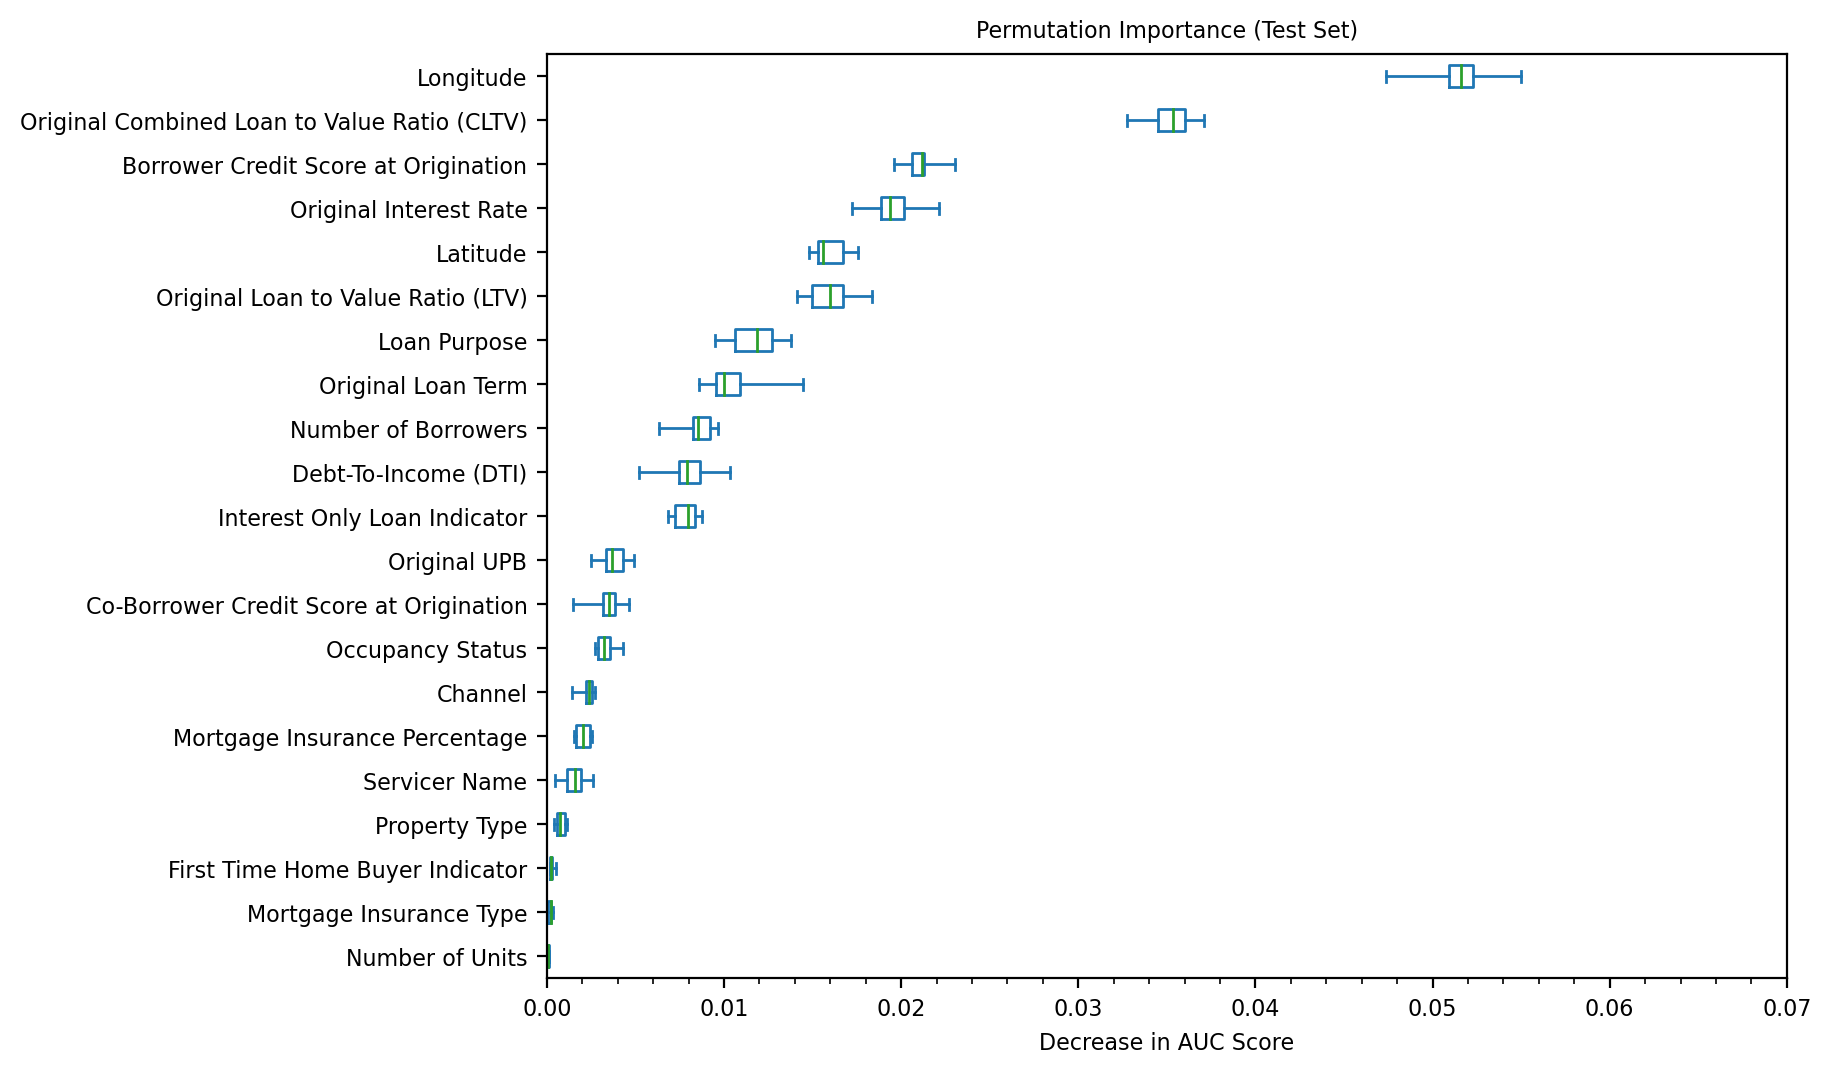

In [39]:
ax = importances.plot.box(vert=False, whis=10, figsize=(8, 6), fontsize=8)

ax.set_xlim(0, 0.07)
ax.set_xlabel('Decrease in AUC Score', fontsize=8)
ax.set_title('Permutation Importance (Test Set)', fontsize=8)

ax.minorticks_on()
ax.yaxis.set_tick_params(which='minor', bottom=False)
ax.xaxis.set_tick_params(which='minor', bottom=True)

Permutation importance determined that longitude was the single most valuable feature in identifying borrowers at risk of default, along with the original loan-to-value ratio, borrower credit score, and interest rate at origination.